In [1]:
datasets = ['CUB', 'Derm7pt', 'RIVAL10']
use_dataset = datasets[1]

In [2]:
import os
import sys

notebook_dir = os.getcwd()
project_root_path = os.path.dirname(notebook_dir)
sys.path.insert(0, project_root_path)

from src.config import CUB_CONFIG, DERM7PT_CONFIG, RIVAL10_CONFIG  # noqa: E402
from src.config import PROJECT_ROOT  # noqa: E402
import numpy as np  # noqa: E402

In [3]:
if use_dataset == 'CUB':
    config_dict = CUB_CONFIG
    DATASET_PATH =  os.path.join(PROJECT_ROOT, 'output', 'CUB')
elif use_dataset == 'Derm7pt':
    config_dict = DERM7PT_CONFIG
    DATASET_PATH =  os.path.join(PROJECT_ROOT, 'output', 'Derm7pt')
else:
    config_dict = RIVAL10_CONFIG
    DATASET_PATH =  os.path.join(PROJECT_ROOT, 'output', 'RIVAL10')

# Load and Transform Data

In [4]:
# INSTANCE-BASED CUB MODEL

# C_train = np.load(os.path.join(PROJECT_ROOT, 'output', 'CUB', 'C_train_instance.npy'))
# C_hat_train = np.load(os.path.join(PROJECT_ROOT, 'output', 'CUB', 'C_hat_sigmoid_train_instance.npy'))
# one_hot_Y_train = np.load(os.path.join(PROJECT_ROOT, 'output', 'CUB', 'Y_train_instance.npy'))

# C_test = np.load(os.path.join(PROJECT_ROOT, 'output', 'CUB', 'C_test_instance.npy'))
# C_hat_test = np.load(os.path.join(PROJECT_ROOT, 'output', 'CUB', 'C_hat_sigmoid_test_instance.npy'))
# one_hot_Y_test = np.load(os.path.join(PROJECT_ROOT, 'output', 'CUB', 'Y_test_instance.npy'))

In [5]:
C_hat_train = np.load(os.path.join(DATASET_PATH, 'C_hat_sigmoid_train.npy'))
one_hot_Y_train = np.load(os.path.join(DATASET_PATH, 'Y_train.npy'))

C_hat_test = np.load(os.path.join(DATASET_PATH, 'C_hat_sigmoid_test.npy'))
one_hot_Y_test = np.load(os.path.join(DATASET_PATH, 'Y_test.npy'))

if use_dataset == 'Derm7pt':
    C_hat_val = np.load(os.path.join(DATASET_PATH, 'C_hat_sigmoid_val.npy'))
    one_hot_Y_val = np.load(os.path.join(DATASET_PATH, 'Y_val.npy'))

    C_hat_train = np.concatenate((C_hat_train, C_hat_val), axis=0)
    one_hot_Y_train = np.concatenate((one_hot_Y_train, one_hot_Y_val), axis=0)

class_level_concepts = np.load(os.path.join(DATASET_PATH, 'class_level_concepts.npy'))

In [6]:
Y_train = np.argmax(one_hot_Y_train, axis=1)
Y_test = np.argmax(one_hot_Y_test, axis=1)

In [7]:
C_train = []
for y in Y_train:
    C_train.append(class_level_concepts[y])

C_train = np.array(C_train)

In [8]:
# from sklearn.utils import shuffle


# C_hat_train, C_train, one_hot_Y_train, Y_train = shuffle(C_hat_train, C_train, one_hot_Y_train, Y_train, random_state=42)

In [9]:
# unique, counts = np.unique(Y_train, return_counts=True)
# for label, count in zip(unique, counts):
#     print(f"Label {label}: {count} instances")

In [10]:
# unique, counts = np.unique(Y_test, return_counts=True)
# for label, count in zip(unique, counts):
#     print(f"Label {label}: {count} instances")

# Classic Models

## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(C_hat_train, Y_train)
print(f"Logistic Regression Test accuracy: {model.score(C_hat_test, Y_test)}")

Logistic Regression Test accuracy: 0.6025316455696202


In [12]:
np.unique(model.predict(C_hat_test))

array([1, 2])

## k-NN

In [13]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(C_hat_train, Y_train)
print(f"k-NN Test accuracy: {model.score(C_hat_test, Y_test)}")

k-NN Test accuracy: 0.529113924050633


In [14]:
np.unique(model.predict(C_hat_test))

array([0, 1, 2, 3])

## Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(C_hat_train, Y_train)
print(f"Decision Tree Test accuracy: {model.score(C_hat_test, Y_test)}")

Decision Tree Test accuracy: 0.4481012658227848


In [16]:
np.unique(model.predict(C_hat_test))

array([0, 1, 2, 3, 4])

## MLP

In [17]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(512,256, 128), max_iter=1000)
mlp.fit(C_hat_train, Y_train)
print(f"MLP Test accuracy: {mlp.score(C_hat_test, Y_test)}")

MLP Test accuracy: 0.5721518987341773


In [18]:
np.unique(model.predict(C_hat_test))

array([0, 1, 2, 3, 4])

# Accuracy Using Class-Level Concepts

In [19]:
# Function to find the closest concept vector and predict the label
def predict_nearest_concept(instance, reference_concepts, reference_labels):
    distances = np.sqrt(np.sum((reference_concepts - instance)**2, axis=1))
    min_idx = np.argmin(distances)
    return reference_labels[min_idx]

# Use C_train as reference concepts and evaluate on C_hat_test
correct_predictions = 0
total_predictions = len(C_hat_test)

for i, test_instance in enumerate(C_hat_test):
    predicted_label = predict_nearest_concept(test_instance, C_train, Y_train)
    true_label = Y_test[i]

    if predicted_label == true_label:
        correct_predictions += 1

# Calculate and print accuracy
accuracy = correct_predictions / total_predictions
print(f"\nOverall accuracy using concept-based nearest neighbor: {accuracy:.4f}")


Overall accuracy using concept-based nearest neighbor: 0.6481


# Prototype-Based Model


In [20]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## Create Dataloaders

In [22]:
val_split_ratio = 0.2
random_seed = 42

if use_dataset == 'Derm7pt':
    X_train = torch.tensor(C_hat_train, dtype=torch.float32)
    Y_train = torch.tensor(one_hot_Y_train, dtype=torch.float32)
else:
    # C_hat_train, C_hat_val, Y_train_np, Y_val_np = train_test_split(C_hat_train, one_hot_Y_train, test_size=val_split_ratio, random_state=random_seed)
    X_train = torch.tensor(C_hat_train, dtype=torch.float32)
    Y_train = torch.tensor(one_hot_Y_train, dtype=torch.float32)

X_test = torch.tensor(C_hat_test, dtype=torch.float32, device=device)
Y_test = torch.tensor(one_hot_Y_test, dtype=torch.float32, device=device)

# DATALOADERS
batch_size = 64
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Learn Prototypes

In [23]:
import numpy as np
import torch
import torch.nn as nn

class PrototypeClassifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.protoypes = nn.Parameter(torch.rand(num_classes, num_features))  # initialize the prototype matrix P

    def forward(self, x):
        # x: (batch_size, num_features)
        # L1distance：|x_i - M_m|_1
        # (batch_size, num_classes, num_features)
        dist = torch.abs(x.unsqueeze(1) - torch.sigmoid(self.protoypes))
        dist = dist.sum(dim=2)
        return dist  # (batch_size, num_classes)

    def binary_regularization(self):
        sigmoid_protos = torch.sigmoid(self.protoypes)
        return (sigmoid_protos * (1 - sigmoid_protos)).mean()

    def sparsity_regularization(self):
        return torch.sum(torch.sigmoid(self.protoypes))

    def predict(self, x):
        with torch.no_grad():
            Prototypes = torch.sigmoid(self.protoypes)
            Prototypes[Prototypes>=0.5] = 1
            Prototypes[Prototypes<0.5]= 0
            dists = torch.abs(x.unsqueeze(1) - Prototypes)
            dists = dists.sum(dim=2)
            predictions = dists.argmin(dim=1)
        return predictions

    def get_sigmoid_prototypes(self):
        return torch.sigmoid(self.protoypes)

    def get_binary_prototypes(self):
        Prototypes = torch.sigmoid(self.protoypes)
        Prototypes[Prototypes>=0.5] = 1
        Prototypes[Prototypes<0.5]= 0
        return Prototypes

    def concept_wise_dist(self, x):
        with torch.no_grad():
            Prototypes = torch.sigmoid(self.protoypes)
            Prototypes[Prototypes>=0.5] = 1
            Prototypes[Prototypes<0.5]= 0
            dists = x.unsqueeze(1) - Prototypes
            # predictions = self.predict(x)
            # dists = dists[torch.arange(x.shape[0]), predictions,:]
        return dists

    def threshold(self, val_x, val_y, percentile=0.98):
        self.eval()
        with torch.no_grad():
            dists = self(val_x)
            min_dists = dists.min(dim=1).values.cpu().numpy()

            # y_val is one-hot or not ?
            if val_y.ndim > 1 and val_y.shape[1] > 1:
                real_labels = val_y.argmax(dim=1).cpu()
            else:
                real_labels = val_y

            pred_labels = self.predict(val_x).cpu()
            matching_array = (pred_labels == real_labels).numpy()

            correct_min_dists = min_dists[matching_array]
            correct_min_dists.sort()

            self.computed_threshold_ = np.percentile(correct_min_dists, percentile * 100)
            print(f"Threshold computed: {self.computed_threshold_:.4f} using {len(correct_min_dists)} correctly classified validation samples at {percentile*100:.1f}th percentile.")
        return self.computed_threshold_

    def outlier_predict(self, x):
        self.eval()
        with torch.no_grad():
            dists_x = self(x)
            min_dists_x = dists_x.min(dim=1).values
            predictions = self.predict(x)

            # Identify inliers
            is_inlier = min_dists_x.cpu() <= self.computed_threshold_

            # Return predictions, but mark outliers with a -1
            conformal_predictions = predictions.clone()
            conformal_predictions[~is_inlier.to(predictions.device)] = -1

        return conformal_predictions, is_inlier

    def conformal_predict(self, x):
        pass

    def explanation(self, x, y_hat):
        pred = self.predict(x.unsqueeze(0))
        concept_dists = x - self.get_binary_prototypes()[pred]
        return concept_dists
        # self.prototypes[y_hat]
        # take in c_hat, find relevant prototype from y_hat
        # do np.abs(c_hat-prototype)
        # to-do: how to do a global explanation from local explanations

In [24]:
# from src.models import PrototypeClassifier

num_concepts = config_dict['N_TRIMMED_CONCEPTS']
num_classes = config_dict['N_CLASSES']

model = PrototypeClassifier(num_concepts, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lambda_binary = 0.01
lambda_L1 = 0.001

In [25]:
# train and test
from tqdm import tqdm
from src.training import train_epoch

num_epochs = 50
best_acc, best_epoch = 0, 0

tqdm_loader = tqdm(range(num_epochs), desc="Training Prototypes", leave=True)
for epoch in tqdm_loader:
    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, lambda_binary, lambda_L1, device=device)
    if train_accuracy > best_acc:
        best_acc = train_accuracy
        best_epoch = epoch
    tqdm_loader.set_postfix({"Train Acc": f"{train_accuracy:.2f}%", "Train Loss": f"{train_loss:.4f}"})

print(f"Best accuracy of {best_acc:.2f}% achieved at epoch {best_epoch}")

Training Prototypes: 100%|██████████| 50/50 [00:04<00:00, 12.37it/s, Train Acc=55.68%, Train Loss=-7.3214]

Best accuracy of 57.63% achieved at epoch 20


In [26]:
real_labels = Y_test.argmax(dim=1)
predictions = model.predict(X_test)
(predictions == real_labels).sum().item()/len(predictions)

0.6455696202531646

In [27]:
dists = model.explanation(X_test[0], None)
# X_test[0].unsqueeze(1)x/

Top 10 most influential concepts:
Concept 9: 0.5964 (Higher than prototype)
Concept 11: -0.5318 (Lower than prototype)
Concept 14: -0.5159 (Lower than prototype)
Concept 3: -0.5080 (Lower than prototype)
Concept 17: -0.5041 (Lower than prototype)
Concept 12: -0.3454 (Lower than prototype)
Concept 1: 0.2683 (Higher than prototype)
Concept 2: 0.1434 (Higher than prototype)
Concept 16: 0.1175 (Higher than prototype)
Concept 15: 0.1152 (Higher than prototype)


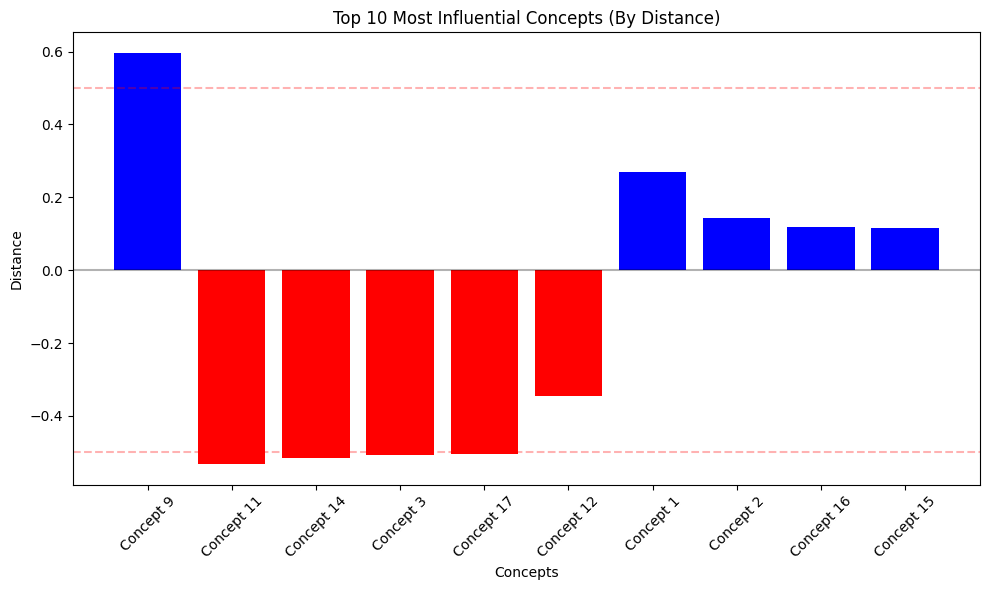

In [29]:
import matplotlib.pyplot as plt

# Convert tensor to numpy for easier visualization
dists_np = dists[0].cpu().detach().numpy()

# Sort the data by absolute distance values (largest distances first)
sorted_indices = np.argsort(np.abs(dists_np))[::-1]
sorted_dists = dists_np[sorted_indices]

# Take only the top 10 most important concepts
top_k = 10
sorted_indices = sorted_indices[:top_k]
sorted_dists = sorted_dists[:top_k]

# Create concept names
sorted_concept_names = [f"Concept {i+1}" for i in sorted_indices]

# Create a color map (red for negative, blue for positive)
colors = ['red' if x < 0 else 'blue' for x in sorted_dists]

# Create a bar plot with sorted values
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_dists)), sorted_dists, color=colors)
plt.xticks(range(len(sorted_dists)), sorted_concept_names, rotation=45)
plt.title("Top 10 Most Influential Concepts (By Distance)")
plt.xlabel("Concepts")
plt.ylabel("Distance")
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.3, label='False Positive')
plt.axhline(y=-0.5, color='red', linestyle='--', alpha=0.3, label='False Negative')
plt.tight_layout()

# Print the top most influential concepts
print("Top 10 most influential concepts:")
for i in range(len(sorted_indices)):
    idx = sorted_indices[i]
    value = dists_np[idx]
    direction = "Higher than prototype" if value > 0 else "Lower than prototype"
    print(f"Concept {idx+1}: {value:.4f} ({direction})")

plt.show()